# Example 01: Linear Regression

In [1]:
import numpy as np
import torch
from torch import Tensor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt # plotting packages
from IPython.display import clear_output, display # utilities to update plots in Jupyter

In [2]:
np.random.seed(1337)
torch.manual_seed(1337)

## 0. Toy data generation

In [3]:
def linear_regression_model(x: Tensor, w: Tensor, b: Tensor) -> Tensor:
    # check that input features match weight size
    assert x.size(1) == w.size(0)
    # check that bias is a single number
    assert len(b) == 1
    # compute y = x·w + b
    return (w * x).sum(dim=1) + b

def mse_loss(y, t):
    # # compute mean squared error (without averaging yet)
    loss = (y - t)**2 / 2
    return loss.mean()

In [4]:
num_features = 2 # the number of input features
num_examples = 1000 # total number of data points 

# true weights and bias
w_true = torch.tensor([-1, 2], dtype=torch.float32)
b_true = torch.tensor([1], dtype=torch.float32)

x_total = torch.randn(num_examples, num_features)
t_total = linear_regression_model(x_total, w_true, b_true)

# split data into training and test sets
x_train, x_test, t_train, t_test = train_test_split(x_total, t_total, test_size=0.2)
# further split training data into train and validation sets
x_train, x_val, t_train, t_val = train_test_split(x_train, t_train, test_size=0.2)

## 1. Build a linear regression model from scratch using PyTorch 

### adjustable parameters

In [5]:
# weights
w = torch.randn(num_features, requires_grad=True)
# bias
b = torch.zeros(1, requires_grad=True)

In [6]:
print(f'{w=}')
print(f'{b=}')

w=tensor([-0.2277, -1.2632], requires_grad=True)
b=tensor([0.], requires_grad=True)


### Training Step

In [7]:
# take a small batch
x = x_train[:8]
t = t_train[:8]

print(f'{x=}')
print(f'{t=}')

x=tensor([[ 0.5464,  0.6994],
        [-1.4546,  0.2410],
        [-0.3098, -1.7464],
        [ 0.7527, -0.8036],
        [ 0.2341, -0.0326],
        [-2.2488,  1.2301],
        [ 0.0808,  2.6207],
        [-2.2630, -0.2638]])
t=tensor([ 1.8524,  2.9366, -2.1831, -1.3599,  0.7007,  5.7089,  6.1606,  2.7354])


In [8]:
# forward pass
y = linear_regression_model(x, w, b)
print(f'{y=}')

y=tensor([-1.0078,  0.0268,  2.2766,  0.8436, -0.0121, -1.0417, -3.3288,  0.8485],
       grad_fn=<AddBackward0>)


In [9]:
# squared errors
per_example_loss = (y - t)**2
print(f'{per_example_loss=}')

per_example_loss=tensor([ 8.1808,  8.4670, 19.8890,  4.8555,  0.5081, 45.5709, 90.0484,  3.5604],
       grad_fn=<PowBackward0>)


In [10]:
loss = per_example_loss.mean()
print(f'{loss=}')

loss=tensor(22.6350, grad_fn=<MeanBackward0>)


In [11]:
# backpropagate to compute gradients
loss.backward()

In [12]:
print(f'{w.grad=}')
print(f'{b.grad=}')

w.grad=tensor([  5.3661, -11.2281])
b.grad=tensor([-4.4866])


### Gradients can be accumulated

In [13]:
y = linear_regression_model(x, w, b)
loss = mse_loss(y, t).mean()

print(f'{w.grad=}')
print(f'{b.grad=}')

loss.backward(retain_graph=True)
print(f'{w.grad=}')
print(f'{b.grad=}')

loss.backward(retain_graph=True)
print(f'{w.grad=}')
print(f'{b.grad=}')

loss.backward(retain_graph=True)
print(f'{w.grad=}')
print(f'{b.grad=}')

w.grad=tensor([  5.3661, -11.2281])
b.grad=tensor([-4.4866])
w.grad=tensor([  8.0492, -16.8421])
b.grad=tensor([-6.7299])
w.grad=tensor([ 10.7323, -22.4561])
b.grad=tensor([-8.9732])
w.grad=tensor([ 13.4153, -28.0701])
b.grad=tensor([-11.2166])


### Gradient Descent with a minibatch 

In [14]:
y = linear_regression_model(x, w, b)
loss = mse_loss(y, t).mean()
loss.backward()

print('Before GD')
print(f'{w=}')
print(f'{b=}')

lr = 0.1

with torch.no_grad():
    w.data -= lr * w.grad.data
    b.data -= lr * b.grad.data
    # clear gradients to prevent accumulation
    w.grad = None
    b.grad = None


print()
print('After GD')
print(f'{w=}')
print(f'{b=}')

Before GD
w=tensor([-0.2277, -1.2632], requires_grad=True)
b=tensor([0.], requires_grad=True)

After GD
w=tensor([-1.8376,  2.1052], requires_grad=True)
b=tensor([1.3460], requires_grad=True)


## 2. Fit

### Hyperparameters

In [15]:
lr = 0.1
batch_size = 64
max_epochs = 50

### Reset the model parameters

In [16]:
# reset the model parameters
torch.nn.init.normal_(w) # reinitialize weights from normal distribution

# bias
b.data.zero_() # reset bias to zero

tensor([0.])

In [17]:
# a function to visualize learning curves
def plot_curve(train_step, train_loss, val_step, val_loss):
    # clear previous plot
    clear_output(wait=True)
    fig, ax = plt.subplots()
    # plot training loss
    ax.plot(train_step, train_loss, label='Training', ls=':', marker='o')
    # plot validation loss
    ax.plot(val_step, val_loss, label='Validation', ls='--', marker='s')
    ax.set_xlabel('Step')      # x-axis label
    ax.set_ylabel('MSE Loss')  # y-axis label
    ax.legend(loc='upper right')  # show legend
    display(fig)  # display the plot
    plt.close(fig)  # close the figure to save memory

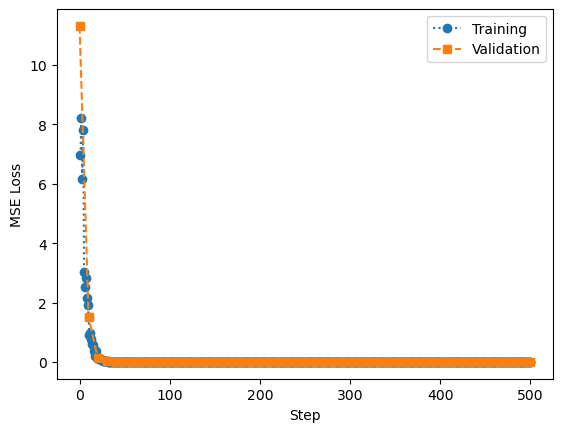

In [18]:
# prepare lists for plotting
# training curve
train_step_list: list[int] = []
train_loss_list: list[float] = []
# validation curve
val_step_list: list[int] = []
val_loss_list: list[float] = []

step = 0 # counter for training iterations

# training and validation loop
for epoch in range(0, max_epochs + 1):
    if epoch > 0:
        # --- TRAINING ---
        
        # shuffled example indices for random sampling -> stochastic gradient descent
        train_shuffled_indices = torch.randperm(len(x_train))
        for batch_indices in train_shuffled_indices.split(batch_size):
            x, t = x_train[batch_indices], t_train[batch_indices]

            y = linear_regression_model(x, w, b)
            loss = mse_loss(y, t).mean()
            
            loss.backward()
            with torch.no_grad():
                for param in [w, b]:
                    param.data -= lr * param.grad.data
                    param.grad = None

            step += 1

            train_step_list.append(step)
            train_loss_list.append(loss.item())
    
    #  --- VALIDATION ---
    val_loss_sum = 0

    with torch.no_grad(): # disable gradient computation for validation
        for batch_indices in torch.arange(len(x_val)).split(batch_size):
            x, t = x_val[batch_indices], t_val[batch_indices]
        
            y = linear_regression_model(x, w, b)
            val_loss_sum += loss.sum().item()* len(x)
    
    val_step_list.append(step)
    # average validation loss
    val_loss_list.append(val_loss_sum / len(x_val))

    # update the plot after each epoch
    plot_curve(train_step_list, train_loss_list, val_step_list, val_loss_list)

# 3. (Optional) Hyperparameter tuning 

In [20]:
# you can compare different learning rates, differnt batch sizes

## 4. Testing

In [21]:
test_loss_sum = 0

with torch.no_grad():
    for batch_indices in torch.arange(len(x_test)).split(batch_size):
        x, t = x_test[batch_indices], t_test[batch_indices]
        y = linear_regression_model(x, w, b)
        loss = mse_loss(y, t)
        test_loss_sum += loss.sum().item()

test_loss = test_loss_sum / len(x_test)

In [22]:
print(f'{test_loss:=.4e}')

1.6939e-15


### Compare learned parameters to true values

In [23]:
print(f'{w_true=}, {w=}')
print(f'{b_true=}, {b=}')

w_true=tensor([-1.,  2.]), w=tensor([-1.0000,  2.0000], requires_grad=True)
b_true=tensor([1.]), b=tensor([1.0000], requires_grad=True)
